# Where are we going?

This notebook demonstrates reading and analysing the HRRR forecast data cube.

It requires the `pvlib` package to download public NOAA SOLRAD data

```
mamba install -c conda-forge pvlib
```

## Helper functions

In [1]:
import matplotlib.pyplot as plt
import hvplot.xarray

import hvplot.xarray
import colorcet
from datetime import datetime


plt.style.use("seaborn-v0_8-whitegrid")


def compare_to_solrad(station, ds, solrad, *, show_solrad=True):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from cycler import cycler

    st = solrad.sel(station=station, time=slice(ds.valid_time[0, 0], None))

    subset = subselect(ds, lat=st.latitude, lon=st.longitude)[
        ["dswrf", "tcc", "ghi"]
    ].compute()

    nsteps = subset.sizes["step"]
    with plt.rc_context(
        {
            "axes.prop_cycle": cycler(
                color=mpl.cm.Blues.resampled(nsteps + 2)(range(2, nsteps + 2))
            )
        }
    ):
        subset.ghi.sortby("step", ascending=False).plot.line(
            x="valid_time",
            hue="step",
            add_legend=False,
            aspect=6,
            size=2.5,
        )
    if show_solrad:
        st.ghi.resample(time="h").mean(engine="flox").plot(
            ax=plt.gca(),
            color="r",
            lw=2,
            label="Ground Truth SOLRAD",
            _labels=False,
        )
    from datetime import datetime

    plt.axvline(datetime.utcnow(), color="k", ls="--")
    plt.title(f"station={st.long_name.data}")
    plt.gca().set_ylim([0, 1200])
    plt.legend()


def subselect(ds, *, lat, lon):
    dist = (ds.latitude - lat) ** 2 + (ds.longitude - lon) ** 2
    subset = ds.isel(**dist.argmin(("y", "x"))).chunk()

    # Larson et al. (2016)
    subset["ghi"] = subset.dswrf * (0.35 + 0.65 * (1 - subset.tcc / 100))
    subset.ghi.attrs = {"long_name": "Global Horizontal Incidence", "units": "$W/m^2$"}
    return subset


def postprocess_forecast(ds):
    ds.coords["valid_time"] = ds.time + ds.step
    ds.valid_time.attrs = {"long_name": "Forecast time"}
    ds.time.attrs["long_name"] = "Forecast initialization time"
    ds.latitude.load()
    ds.longitude.load()
    ds["step"] = (
        "step",
        np.arange(ds.sizes["step"]),
        {"long_name": "Forecast step", "units": "hours"},
    )
    return ds

## Real data

In [2]:
from datetime import datetime
import pandas as pd


def download_solrad(start, end):
    import pvlib
    import xarray as xr

    from dataclasses import dataclass

    @dataclass
    class Station:
        name: str
        long_name: str
        longitude: float
        latitude: float

    SOLRAD_STATIONS = [
        Station(
            name="abq", long_name="Albuquerque", latitude=35.03796, longitude=-106.62211
        ),
        # Station(
        #    name="bis", long_name="Bismarck", latitude=46.77179, longitude=-100.75955
        # ),
        # Station(
        #    name="hnx", long_name="Hanford", latitude=36.31357, longitude=-119.63164
        # ),
        # Station(
        #    name="msn", long_name="Madison", latitude=43.07250, longitude=-89.41133
        # ),
        Station(
            name="sea", long_name="Seattle", latitude=47.68685, longitude=-122.25667
        ),
        # Station(
        #    name="slc",
        #    long_name="Salt Lake City",
        #    latitude=40.77220,
        #    longitude=-111.95495,
        # ),
    ]
    dsets = []
    for station in SOLRAD_STATIONS:
        data, metadata = pvlib.iotools.get_solrad(station.name, start=start, end=end)
        as_ds = (
            data.to_xarray()[["ghi"]]
            .rename(index="time")
            .assign_coords(
                latitude=station.latitude,
                longitude=station.longitude,
                station=station.name,
                long_name=station.long_name,
            )
            .expand_dims("station")
        )
        as_ds["time"] = ("time", data.index.tz_localize(None))
        dsets.append(as_ds)
    return xr.concat(dsets, "station")


now = pd.Timestamp(datetime.utcnow()).round("D")
solrad = download_solrad(now - pd.Timedelta("5D"), now)

/srv/conda/envs/notebook/lib/python3.11/site-packages/pvlib/iotools/solrad.py:211: UserWarning: The following file was not found: abq/2024/abq24163.dat
  warnings.warn(f"The following file was not found: {f}")
/srv/conda/envs/notebook/lib/python3.11/site-packages/pvlib/iotools/solrad.py:211: UserWarning: The following file was not found: abq/2024/abq24164.dat
  warnings.warn(f"The following file was not found: {f}")
/srv/conda/envs/notebook/lib/python3.11/site-packages/pvlib/iotools/solrad.py:211: UserWarning: The following file was not found: abq/2024/abq24165.dat
  warnings.warn(f"The following file was not found: {f}")
/srv/conda/envs/notebook/lib/python3.11/site-packages/pvlib/iotools/solrad.py:211: UserWarning: The following file was not found: sea/2024/sea24163.dat
  warnings.warn(f"The following file was not found: {f}")
/srv/conda/envs/notebook/lib/python3.11/site-packages/pvlib/iotools/solrad.py:211: UserWarning: The following file was not found: sea/2024/sea24164.dat
  warnin

## HRRR - Analysis-Ready Data Cube

In [3]:
import arraylake as al
import numpy as np

client = al.Client()
repo = client.get_repo("earthmover-demos/hrrr")
repo.tree()

Tree(nodes=(Node(name='/', nodes=(Node(name='solar', nodes=(Node(icon='table', name='tcc (1799, 1059, 740, 49)…

In [4]:
hrrr = repo.to_xarray("solar")
hrrr = postprocess_forecast(hrrr)
hrrr["longitude"] -= 360
hrrr

<xarray.Dataset> Size: 2TB
Dimensions:      (x: 1799, y: 1059, time: 740, step: 49)
Coordinates:
    latitude     (y, x) float64 15MB 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude    (y, x) float64 15MB -122.7 -122.7 -122.7 ... -60.95 -60.92
    spatial_ref  float64 8B nan
  * step         (step) int64 392B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
  * time         (time) datetime64[ns] 6kB 2024-05-12T18:00:00 ... 2024-06-12...
    valid_time   (time, step) datetime64[ns] 290kB 2024-05-12T18:00:00 ... 20...
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, time, step) float32 276GB ...
    gust         (x, y, time, step) float32 276GB ...
    prate        (x, y, time, step) float32 276GB ...
    r2           (x, y, time, step) float32 276GB ...
    t2m          (x, y, time, step) float32 276GB ...
    tcc          (x, y, time, step) float32 276GB ...
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

## What is the latest forecast

### Global Horizontal Irradiance

*Source: [CBE ClimaTool](https://cbe-berkeley.gitbook.io/clima/documentation/tabs-explained/sun-and-cloud/global-and-diffuse-horizontal-solar-radiation/global-diffuse-and-normal-solar-radiation-explained)*
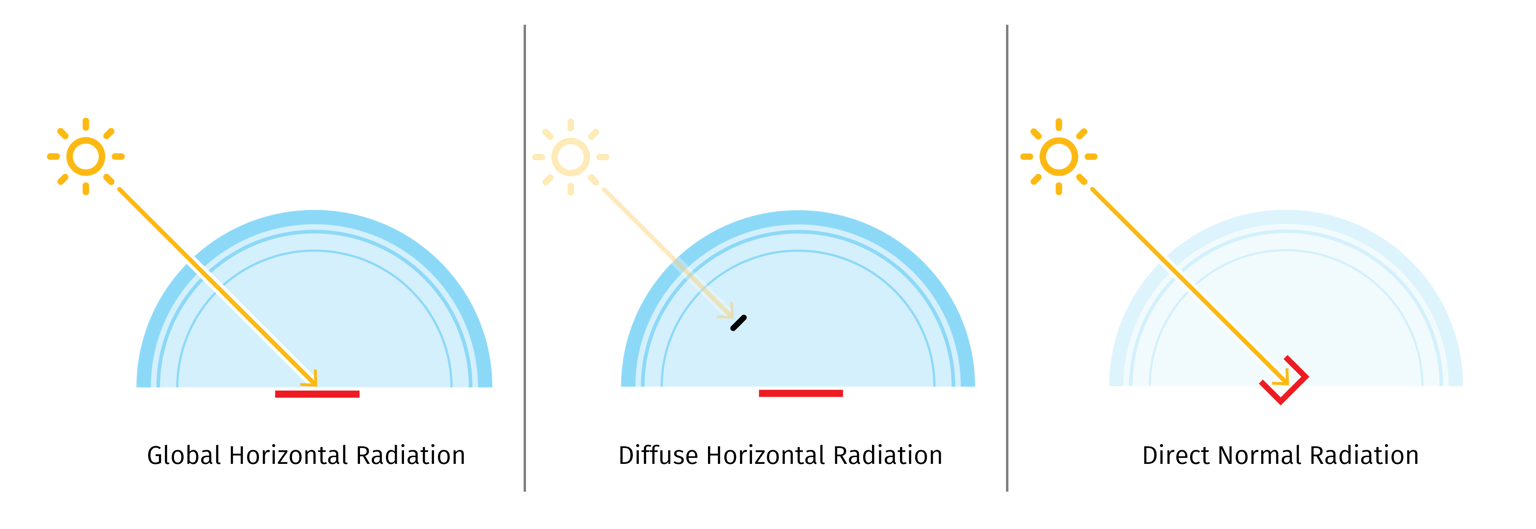



- Forecast models commonly save clear-sky irradiance: $\text{GHI}_\text{CS}$
- Need to account for cloud cover $\text{CC}$
- Follow *Larson et al (2016) - Day-ahead forecasting of solar power output from photovoltaic plants in the American Southwest*

\begin{equation}
\text{GHI} =  \text{GHI}_\text{CS} [0.35 + 0.65 (1-\text{CC})]
\end{equation}

### Latest forecast at a single point

In [5]:
latest = hrrr.isel(time=-1)
latest

<xarray.Dataset> Size: 2GB
Dimensions:      (x: 1799, y: 1059, step: 49)
Coordinates:
    latitude     (y, x) float64 15MB 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude    (y, x) float64 15MB -122.7 -122.7 -122.7 ... -60.95 -60.92
    spatial_ref  float64 8B nan
  * step         (step) int64 392B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
    time         datetime64[ns] 8B 2024-06-12T13:00:00
    valid_time   (step) datetime64[ns] 392B 2024-06-12T13:00:00 ... 2024-06-1...
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, step) float32 373MB ...
    gust         (x, y, step) float32 373MB ...
    prate        (x, y, step) float32 373MB ...
    r2           (x, y, step) float32 373MB ...
    t2m          (x, y, step) float32 373MB ...
    tcc          (x, y, step) float32 373MB ...
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

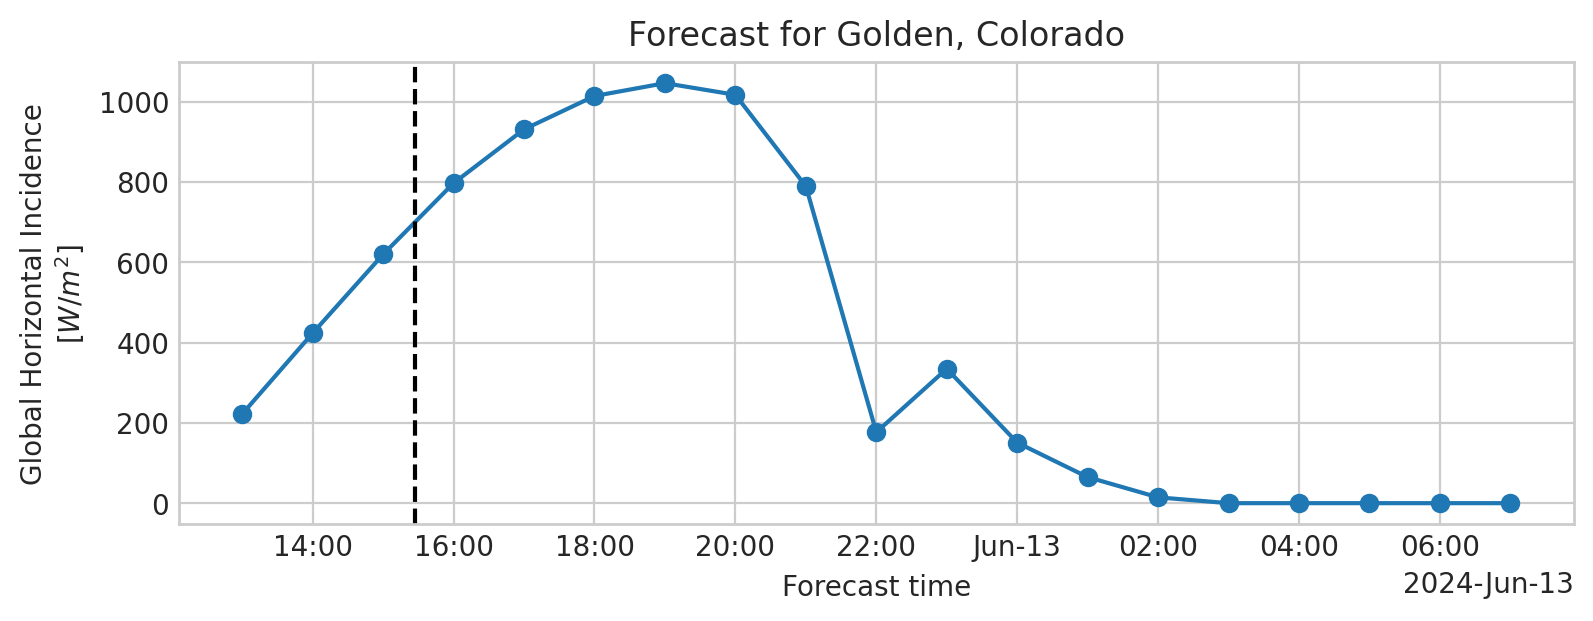

In [6]:
golden = subselect(latest, lat=39.746944, lon=-105.210833)

golden.ghi.plot(x="valid_time", aspect=3, size=3, marker="o")
plt.axvline(datetime.utcnow(), color="k", ls="--")
plt.gca().set_title("Forecast for Golden, Colorado")
plt.gca().set_facecolor([0, 0, 0, 0])
plt.gcf().set_facecolor([0, 0, 0, 0])

### Cloud cover map

In [7]:
cloud_cover = latest.tcc.dropna("step").compute()

In [8]:
import cartopy.crs as ccrs

cloud_cover.hvplot.quadmesh(
    x="longitude",
    y="latitude",
    groupby="step",
    datashade=True,
    rasterize=True,
    cmap="cet_Blues_r",
    widget_location="top",
    features=["coastline", "borders", "states"],
    crs=ccrs.PlateCarree(),
    colorbar=True,
)

Column
    [0] WidgetBox(align=('center', 'start'))
        [0] DiscreteSlider(formatter='%d', name='Forecast step (hours)', options={'0': 0, '1': 1, ...}, value=0)
    [1] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='top')

## How good might it be?

Pick every 18 hour forecast from the last 3 days; every 3rd forecast per day.

In [9]:
recent = hrrr.isel(step=slice(19), time=slice(-3 * 24, None, 3))

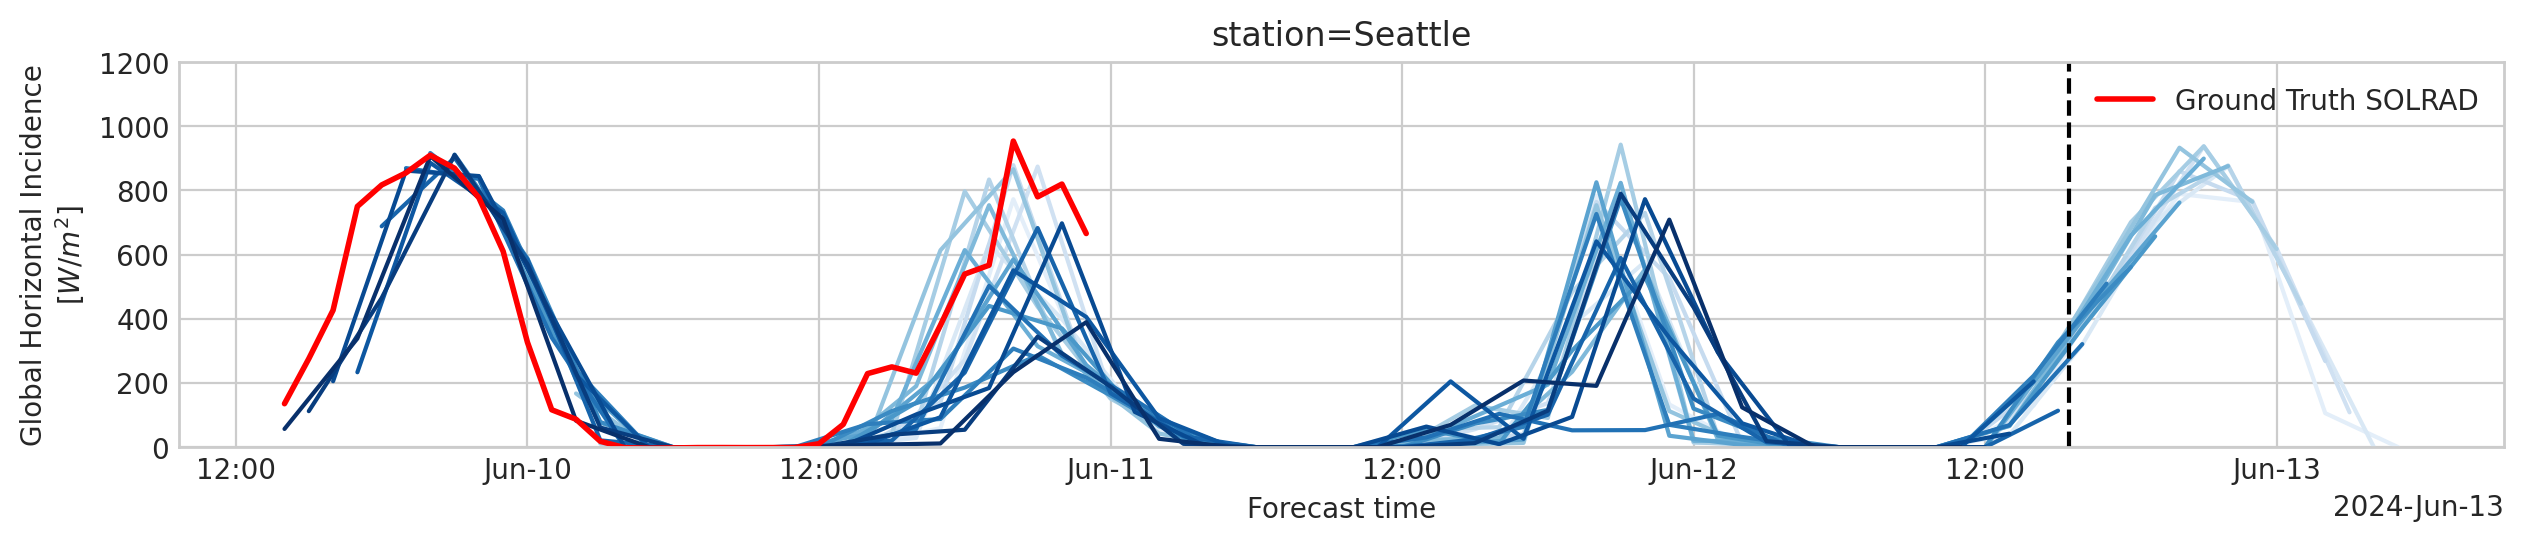

In [10]:
compare_to_solrad("sea", recent, solrad)

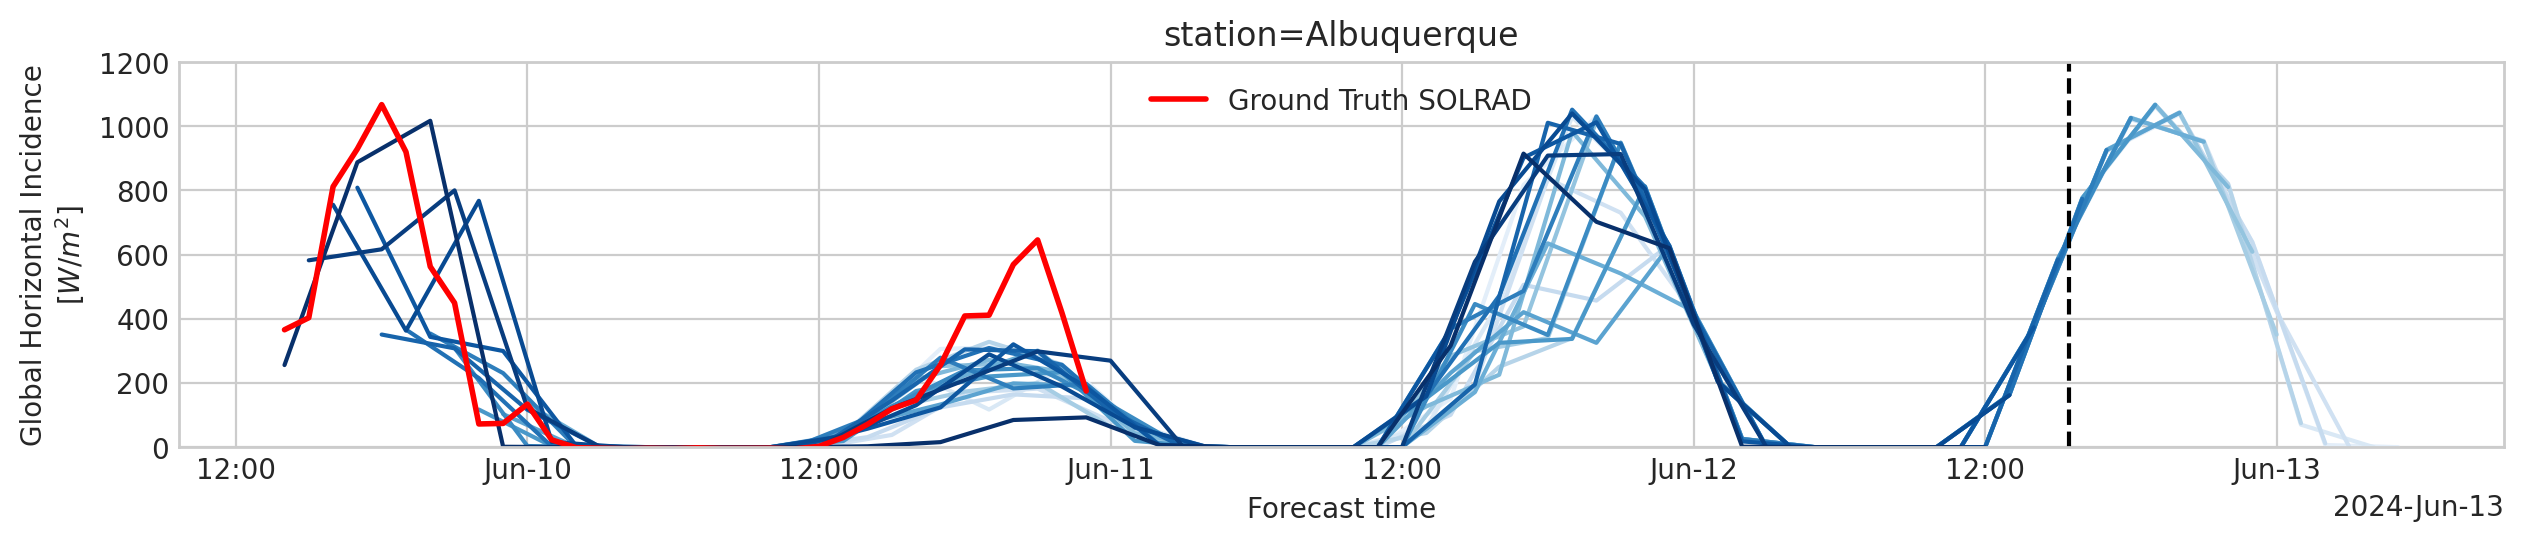

In [11]:
compare_to_solrad("abq", recent, solrad)

## How did we get to that cube?

In [12]:
hrrr

<xarray.Dataset> Size: 2TB
Dimensions:      (x: 1799, y: 1059, time: 740, step: 49)
Coordinates:
    latitude     (y, x) float64 15MB 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude    (y, x) float64 15MB -122.7 -122.7 -122.7 ... -60.95 -60.92
    spatial_ref  float64 8B nan
  * step         (step) int64 392B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
  * time         (time) datetime64[ns] 6kB 2024-05-12T18:00:00 ... 2024-06-12...
    valid_time   (time, step) datetime64[ns] 290kB 2024-05-12T18:00:00 ... 20...
Dimensions without coordinates: x, y
Data variables:
    dswrf        (x, y, time, step) float32 276GB ...
    gust         (x, y, time, step) float32 276GB ...
    prate        (x, y, time, step) float32 276GB ...
    r2           (x, y, time, step) float32 276GB ...
    t2m          (x, y, time, step) float32 276GB ...
    tcc          (x, y, time, step) float32 276GB ...
Attributes:
    description:  HRRR forecast data cube. This dataset is auto-updated by a ...

### This is how the data are distributed.

In [13]:
# Last 3 days near Golden, CO
data = subselect(hrrr.isel(time=slice(-3 * 24, None)), lat=39, lon=-110)

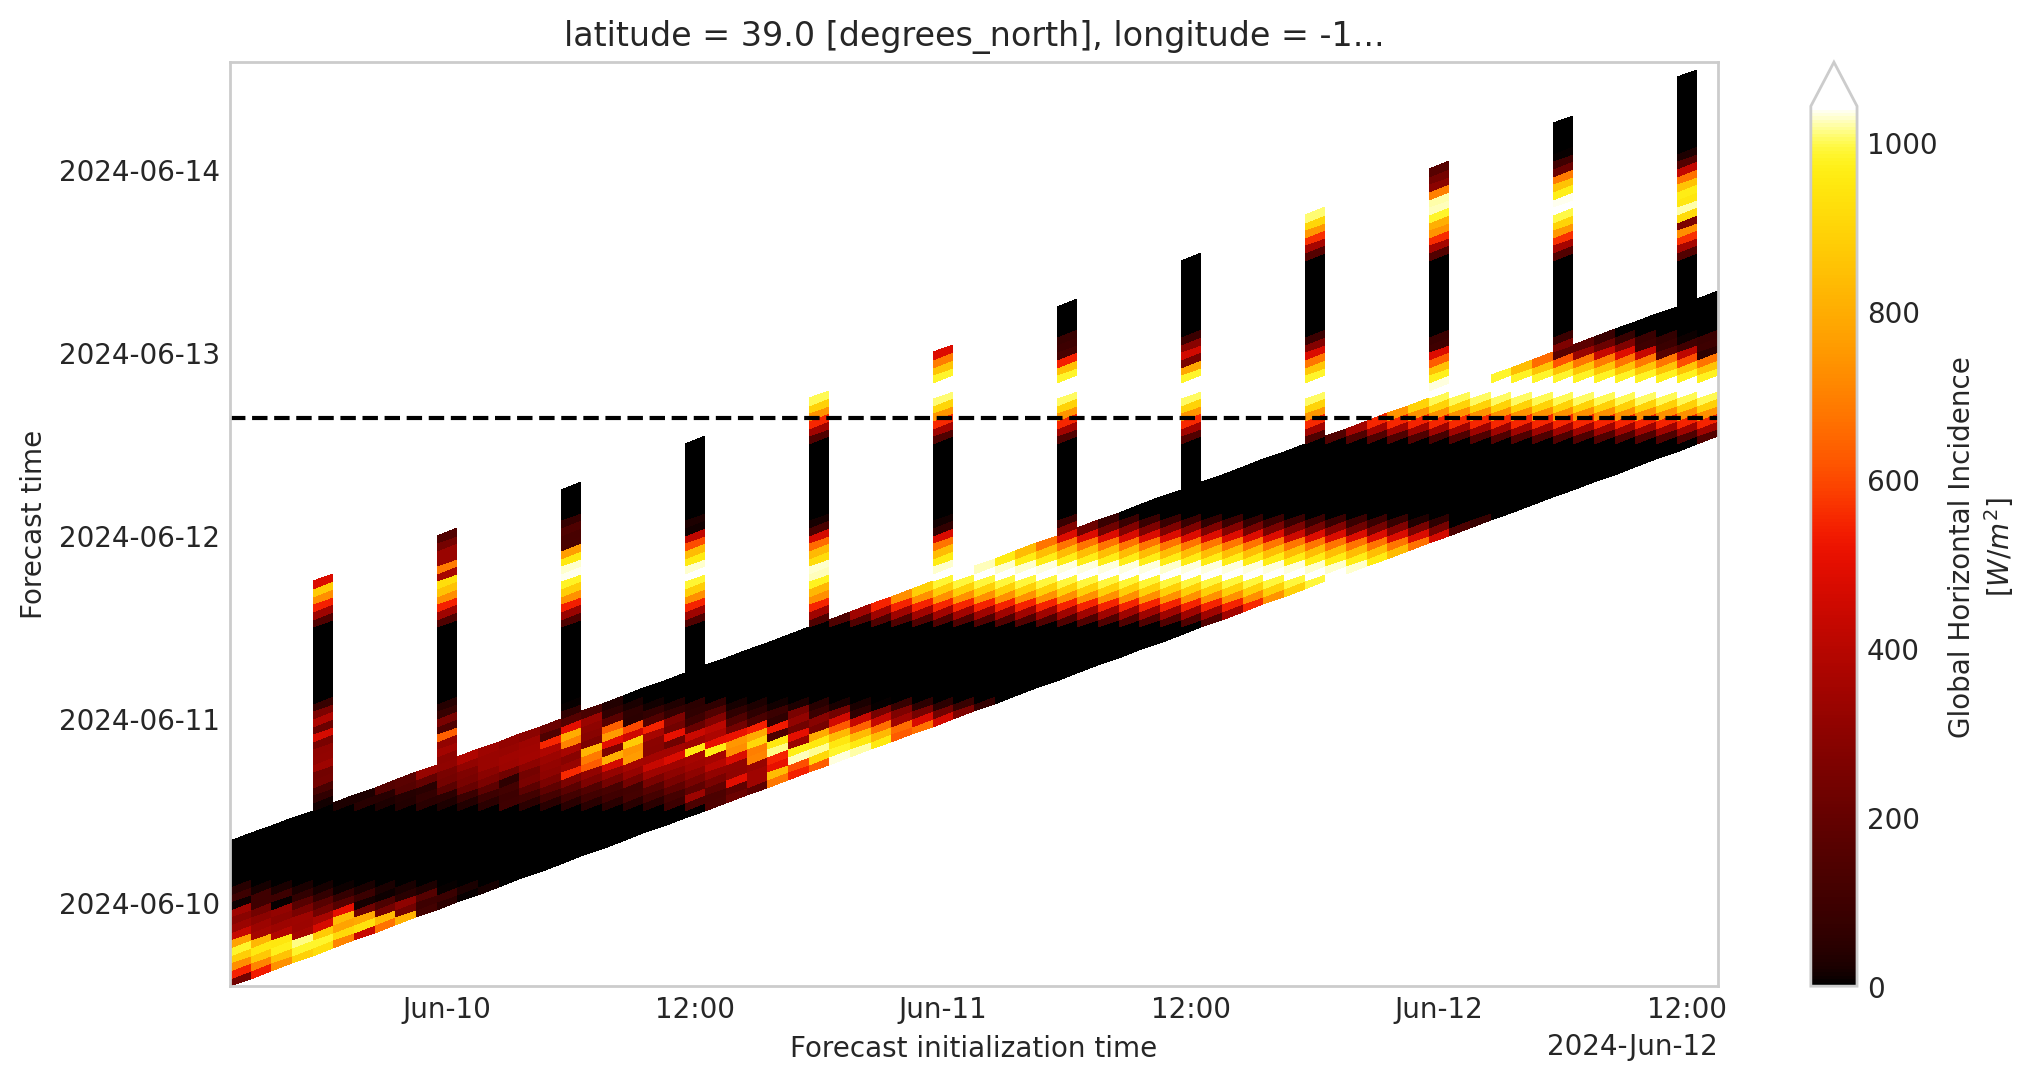

In [14]:
data.ghi.plot(y="valid_time", x="time", cmap="cet_fire", robust=True, aspect=2, size=6)
plt.axhline(datetime.utcnow(), color="k", ls="--")